In [14]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
from PIL import Image

Focus on K=100, L=28 (2 dim), M=2

## Network

In [15]:
class FCN(nn.Module):
    def __init__(self, d=28):
        super().__init__()
        #W
        self.lin1 = nn.Linear(28*28,100)
        #V fix it to 1/100
        self.lin2 = nn.Linear(1,100)
        self.lin2.weight.data=torch.ones(1,100)/100
        self.lin2.bias.data = torch.zeros(1)
        #self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.lin1(x)
        x = F.sigmoid(x)
        x = torch.erf(x / torch.sqrt(torch.tensor(2.0)))
        x = self.lin2(x)
        return x

In [16]:
class MyConv(nn.Module):
    def __init__(self, d=28):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=3, padding=2,
                              padding_mode='circular')
        self.fc = nn.Linear(100,1)
        self.softmax=nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

In [17]:
fc = FCN()

In [18]:
conv = MyConv()

In [19]:
conv(torch.unsqueeze(torch.unsqueeze(inw,0),0))

NameError: name 'inw' is not defined

In [ ]:
W=fc.lin1.weight.data

In [ ]:
torch.mean(W)

In [ ]:
torch.std(W)

In [ ]:
1/(28*28)

In [8]:
def IPR(w):
    return torch.sum(w**4)/(torch.sum(w**2)**2)

In [9]:
def IPR(w):
    return torch.sum(w**4)/(torch.sum(w**2)**2)

In [10]:
def visualize_fields(W):
    """
    W - K x (NxN) matrix
        K number of linear units
        NxN shape of the image
    """
    K,N_squared = W.shape
    N = int(np.sqrt(N_squared))
    for i in range(K):
        print(IPR(W[i]))
        plt.imshow(W[i].reshape((N,N)))
        plt.show()

In [ ]:
#W=fc.lin1.weight.data
#visualize_fields(W)

For binary discrimination tasks, we used {−1, +1} output for the two classes. 

## DATA
non-Gaussian, higher-order local structure
of the inputs,


math.erf(x)


$\epsilon^{-}=2.8$


$\epsilon^{+}=5.6$

Now I got some ok results for

$\epsilon^{+} = 5.6$
$\epsilon^{-} = 1$
$ gain factor=5 $

sigmoid activation

In [101]:
import numpy as np
# define functions
vec_erf = np.vectorize(math.erf)
psi = lambda z: vec_erf(z/(np.sqrt(2)))

gain_factor=5
normalizer = np.sqrt(2/np.pi * np.arcsin(gain_factor**2/(1+gain_factor**2)))
epsilon_plus=5.6
epsilon_minus=5
img_size = 28
mean_vector = np.zeros(img_size)
positive_cov_matrix = np.ones((img_size,img_size))
negative_cov_matrix = np.ones((img_size,img_size))

# Generate a random vector
#random_vector = np.random.multivariate_normal(mean_vector, cov_matrix)

In [102]:
for i in range(img_size):
    for j in range(img_size):
        positive_cov_matrix[i,j] = np.exp(- ( np.abs(i-j) / epsilon_plus)**2 )
positive_cov_matrix=np.kron(positive_cov_matrix,positive_cov_matrix)

In [103]:
for i in range(img_size):
    for j in range(img_size):
        negative_cov_matrix[i,j] = np.exp(- ( np.abs(i-j) / epsilon_minus)**2 )
negative_cov_matrix=np.kron(negative_cov_matrix,negative_cov_matrix)

In [104]:
# def get_positive_example(n=10000):
#     z_mu = np.random.multivariate_normal(np.ones(784), positive_cov_matrix,n)
#     nlgp_z = psi(gain_factor * z_mu)/normalizer
#     return nlgp_z

In [105]:
# def get_negative_example(n=10000):
#     z_mu = np.random.multivariate_normal(np.ones(784), negative_cov_matrix,n)
#     nlgp_z = psi(gain_factor * z_mu)/normalizer
#     return nlgp_z

In [106]:
def get_online_batch(n=1000):
    #np.random.random()
    positive_size=int(0.5*n)
    negative_size=n-positive_size
    
    z_mu_pos = np.random.multivariate_normal(np.zeros(img_size**2), positive_cov_matrix,positive_size)
    positive_dataset = psi(gain_factor * z_mu_pos)/normalizer
    
    z_mu_neg = np.random.multivariate_normal(np.zeros(img_size**2), negative_cov_matrix,negative_size)
    negative_dataset = psi(gain_factor * z_mu_neg)/normalizer
    
    batch = torch.from_numpy(np.vstack([negative_dataset, positive_dataset]).astype(np.float32))
    batch_labels = torch.from_numpy(np.array([-1]*negative_size + [1]*positive_size).astype('float32'))
    # shuffle 
    shuf_idx= torch.randperm(n)
    batch=batch[shuf_idx]
    batch_labels=batch_labels[shuf_idx]
    return batch, batch_labels

In [107]:
batch, b_labels = get_online_batch(10000)

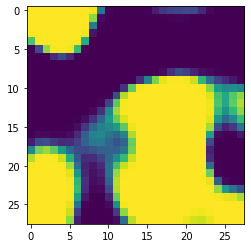

In [108]:
plt.imshow(batch[np.where(b_labels==-1)[0][4]].reshape(28, 28))
plt.savefig("g5ep5.png",dpi=100)

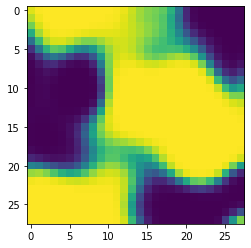

In [74]:
plt.imshow(batch[np.where(b_labels==1)[0][10]].reshape(28, 28))

## Train the net: 

In [ ]:
fc = FCN()

In [ ]:
mse = torch.nn.MSELoss()
optimizer = torch.optim.SGD(fc.parameters(), lr=0.05, momentum=0.9)
#optimizer = torch.optim.Adam(fc.parameters(), lr=0.001)
num_epochs = 10000

In [ ]:
def total_IPR(W):
    return (torch.sum(W**4,dim=1)/(torch.sum(W**2, dim=1))**2)

In [ ]:
save_IPR=[]

In [ ]:
for epoch in tqdm(range(num_epochs)):
    
    inputs, labels = get_online_batch(1000)
    out = fc(inputs)
    loss = mse(out.squeeze(), labels)
    
    ## Backwards pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Train MSE is {loss}\n')
    
    if epoch%10==0:
        with torch.no_grad():
            test_dataset, test_labels=get_online_batch(10000)
            test_outs = fc(test_dataset)
            accuracy = torch.sum( test_outs.sign().squeeze() == test_labels)/len(test_labels)
            print(f"Accuracy is {accuracy}")
            
print('Finished Training')

In [ ]:
W=fc.lin1.weight.data
visualize_fields(W)

In [ ]:
plt.imshow(W[-8].reshape(28,28))

In [ ]:
torch.max(F.softmax(W[2]))

In [ ]:
save_IPR=np.array(save_IPR)

In [ ]:
for i in range(100):
    plt.plot(np.arange(save_IPR.shape[0]),save_IPR[:,i])
plt.show()

In [ ]:
save_IPR[0]

In [ ]:
save_IPR[10000]

## Train Convnet

In [ ]:
conv = MyConv()

In [ ]:
mse = torch.nn.MSELoss()
optimizer = torch.optim.SGD(conv.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(fc.parameters(), lr=0.001)
num_epochs = 10000

In [ ]:
for epoch in tqdm(range(num_epochs)):
    
    inputs, labels = batch_sample(1000)
    inputs = inputs.reshape(1000,1,28,28)
    out = conv(inputs)
    loss = mse(out.squeeze(), labels)
    
    ## Backwards pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'MSE is {loss}\n')
    accuracy = torch.sum( out.sign().squeeze() == labels)
    print(f"Accuracy is {accuracy}")
print('Finished Training')

In [ ]:
from utils import *

In [ ]:
from copy import deepcopy
class MyLin(nn.Module):
    def __init__(self, d=28):
        super().__init__()
        self.lin1 = conv_to_fc(conv.conv1)
        self.fc = deepcopy(conv.fc)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.fc(x)
        return x

In [ ]:
ml = MyLin()

In [ ]:
W=ml.lin1.weight.data
visualize_fields(W)

## Compute Cumulants

In [10]:
import tensorly as tl
from tensorly.decomposition import parafac

In [94]:
sample_dataset = get_online_batch(10000)

In [95]:
batch, b_labels = sample_dataset

In [96]:
np_batch = batch.detach().numpy()

In [97]:
#np_batch=np_batch[b_labels==-1]

In [98]:
mean_matrix =np.mean(np_batch,axis=0)

In [99]:
var_per_pixel = np.zeros((img_size**2,len(np_batch)))

In [45]:
for i in range(img_size**2):
    var_per_pixel[i] = np_batch[:,i] - mean_matrix[i]

In [101]:
cum_mat = np.zeros((img_size**2,img_size**2,img_size**2,img_size**2))

In [12]:
cnt=0
for gain_factor in [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 8 ,10 ]:
    # define functions
    vec_erf = np.vectorize(math.erf)
    psi = lambda z: vec_erf(z/(np.sqrt(2)))

    #gain_factor=0.5
    normalizer = np.sqrt(2/np.pi * np.arcsin(gain_factor**2/(1+gain_factor**2)))
    epsilon_plus=5.6
    epsilon_minus=2.8 
    img_size = 100
    mean_vector = np.zeros(img_size)
    positive_cov_matrix = np.ones((img_size,img_size))
    negative_cov_matrix = np.ones((img_size,img_size))

    # Generate a random vector
    #random_vector = np.random.multivariate_normal(mean_vector, cov_matrix)
    for i in range(img_size):
        for j in range(img_size):
            positive_cov_matrix[i,j] = np.exp(- ( np.abs(i-j) / epsilon_plus)**2 )
    
    for i in range(img_size):
        for j in range(img_size):
            negative_cov_matrix[i,j] = np.exp(- ( np.abs(i-j) / epsilon_minus)**2 )
    
    def get_online_batch(n=1000):
        #np.random.random()
        positive_size=int(0.5*n)
        negative_size=n-positive_size

        z_mu_pos = np.random.multivariate_normal(np.ones(img_size), positive_cov_matrix,positive_size)
        positive_dataset = psi(gain_factor * z_mu_pos)/normalizer

        z_mu_neg = np.random.multivariate_normal(np.ones(img_size), negative_cov_matrix,negative_size)
        negative_dataset = psi(gain_factor * z_mu_neg)/normalizer

        batch = torch.from_numpy(np.vstack([negative_dataset, positive_dataset]).astype(np.float32))
        batch_labels = torch.from_numpy(np.array([-1]*negative_size + [1]*positive_size).astype('float32'))
        # shuffle 
        shuf_idx= torch.randperm(n)
        batch=batch[shuf_idx]
        batch_labels=batch_labels[shuf_idx]
        return batch, batch_labels

    sample_dataset = get_online_batch(10000)
    batch, b_labels = sample_dataset
    batch=batch[b_labels==1]
    cnt+=1
    np.save(f"tilepos{cnt}.npy",batch.detach().numpy())
    b_labels=b_labels[b_labels==1]
#     np_batch = batch.detach().numpy()
#     mean_matrix =np.mean(np_batch,axis=0)
#     var_per_pixel = np.zeros((img_size,len(np_batch)))

#     for i in range(img_size):
#         var_per_pixel[i] = np_batch[:,i] - mean_matrix[i]

#     cum_mat = np.zeros((img_size,img_size,img_size,img_size))


#     for i in tqdm(range(img_size)):
#         for j in range(img_size):
#             for k in range(img_size):
#                 for l in range(img_size):
#                     cum_mat[i,j,k,l] = np.sum(var_per_pixel[i] * var_per_pixel[j] * var_per_pixel[k] * var_per_pixel[l])/(len(np_batch)-1) - \
#                         np.sum(var_per_pixel[i]*var_per_pixel[j])/(len(np_batch)-1) * np.sum(var_per_pixel[k]*var_per_pixel[l])/(len(np_batch)-1) - \
#                         np.sum(var_per_pixel[i]*var_per_pixel[k])/(len(np_batch)-1) * np.sum(var_per_pixel[j]*var_per_pixel[l])/(len(np_batch)-1) - \
#                         np.sum(var_per_pixel[i]*var_per_pixel[l])/(len(np_batch)-1) * np.sum(var_per_pixel[j]*var_per_pixel[k])/(len(np_batch)-1)


#     tensor = tl.tensor(cum_mat)
#     factors = parafac(tensor, rank=1)
#     factor_matrices = factors.factors
#     print(IPR(torch.from_numpy(factor_matrices[0].astype(np.float32))))

In [122]:
sample_dataset[0].shape

torch.Size([10000, 100])

Problems: 
Check means

In [91]:
np.mean(var_per_pixel[i]*var_per_pixel[j])

0.39039608017110133

In [94]:
np.cov(var_per_pixel[i],var_per_pixel[j])[0,1]

0.3983633471133586

In [106]:
cov_value(var_per_pixel[i],var_per_pixel[j])

0.3983633471133587

In [107]:
def cov_value(x,y):

	mean_x = sum(x) / float(len(x))
	mean_y = sum(y) / float(len(y))

	sub_x = [i - mean_x for i in x]
	sub_y = [i - mean_y for i in y]

	sum_value = sum([sub_y[i]*sub_x[i] for i in range(len(x))])
	denom = float(len(x)-1)

	cov = sum_value/denom
	return cov

In [100]:
means

array([2., 6., 5.])

In [ ]:

for i in tqdm(range(img_size**2)):
    for j in range(img_size**2):
        for k in range(img_size**2):
            for l in range(img_size**2):
                cum_mat[i,j,k,l] = np.mean(var_per_pixel[i] * var_per_pixel[j] * var_per_pixel[k] * var_per_pixel[l])

In [86]:
    tensor = tl.tensor(cum_mat)
    factors = parafac(tensor, rank=1)
    factor_matrices = factors.factors
    print(IPR(torch.from_numpy(factor_matrices[0].astype(np.float32))))

tensor(0.0421)


0.0416

In [59]:
np_batch.mean(axis=0).shape

(16,)

In [62]:
np.mean(var_per_pixel[i]*var_per_pixel[j]) 

0.39039608017110133

In [64]:
np.cov(var_per_pixel[i],var_per_pixel[j])

0.4560093787338222